# Calibrating Particle Number for Space Charge in Synergia

I am resurrecting a previous callibration that was done to test various bunch constructors in Synergia. This notebook will repeat as similar exercise in order to validate the new spectral space charge solver we have implemented in Python. The problem remains simulating a beam expanding in a drift.

**Procedure**

1. Construct a drifting beam of known current and simulate it with space charge 
2. Look at the envelope evolution and compare with theory
3. Repeat for 2.5D solver, frozen space charge (Bassetti-Erskine), and 3D open solver

**Particle number convention**

1. The current, I, of interest is that of the beam (not average current)
2. The beam consists of N particles with charge $Q = N e$ (Z = 1 for protons/electrons)
2. Assume beam has length l, velocity $\beta$c, and particles are uniformly distributed
3. The current is then: $I = \frac{Q \beta c}{l}$, and the corresponding number needed is $N = \frac{I l}{\beta c e}$
4. The number of particles per unit length is $\frac{N}{l} = \frac{I}{\beta c e}$ 

**Calculated values and comparison**

With this method, I calculated a proton number scaling of $2.85769 \times 10^8 \frac{p}{m \cdot mA}$, which at 14 mA equates to $4.000763434 \times 10^{9}$ protons per meter.
This corresponds to $5.01 \times 10^{10}$ protons for a completely filled ring (at 4.3 mA), in good agreement with the numbers provided to me by Sasha. 

## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import tables
from mpi4py import MPI

In [3]:
try:
    import rssynergia
except ImportError:
    !pip -q install git+git://github.com/radiasoft/rssynergia

from rssynergia.base_diagnostics import read_bunch
from rssynergia.base_diagnostics import workflow
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import latticework
from rssynergia.base_diagnostics import basic_calcs
from rssynergia.base_diagnostics import pltbunch
from rssynergia.base_diagnostics import elliptic_sp
from rssynergia.base_diagnostics import singleparticle
from rssynergia.base_diagnostics import options
from rssynergia.base_diagnostics import diagplot
from rssynergia.base_diagnostics import utils

from rssynergia.elliptic import elliptic_beam6d
from rssynergia.standard import standard_beam6d

import synergia
import synergia_workflow

## Test problem - Expanding beam in a drift

Benchmarking Parameters:

- 4 m drift (define actively - no need for MADX lattice)

Beam Parameters:

- 14 mA, 2.5 MeV proton beam
- RMS x and y = 1 mm, emittance = 0.3 mm-mrad normalized
- 1 million macro particles
- 64x64 mesh (2D explicit)
- 1 cm step sizes (perhaps do a 2 cm drift with 2 slice per and do 200 turns)
- Bunch length should be a few mm - 5 mm perhaps

In [4]:
# Create and populate a Synergia options object
# File I/O
opts = synergia_workflow.Options("zc_drift")
opts.add("output_dir","sc_drift", "Directory for output files", str)
opts.relpath = opts.output_dir
workflow.make_path(opts.output_dir)
opts.add("verbosity", 1, "Verbosity of propagation", int)
opts.add("bunch_file","myBunch.txt","txt file for bunch particles", str)

# Define reference particle to be a proton at 2.5 MeV
total_energy = synergia.foundation.pconstants.proton_mass + 2.5e-3  # [GeV]
four_momentum = synergia.foundation.Four_momentum(synergia.foundation.pconstants.proton_mass, total_energy)
reference_particle = synergia.foundation.Reference_particle(synergia.foundation.pconstants.proton_charge,four_momentum)
opts.gamma = reference_particle.get_gamma()
opts.beta = reference_particle.get_beta()

# beam (physical)
opts.add("emit",9.74e-6, "H0 value corresponding to real sigma horizontal emittance of 0.3 mm-mrad", float)
opts.add("dpop", 0.0, "Delta-p/p spread", float)
opts.add("real_particles", 1.0e11, "Number of real particles", float)
opts.emit_n = 0.3*1.e-6    # 0.3 mm-mrad normalized emittance
opts.emits = [basic_calcs.calc_geometric_emittance(opts.emit_n,opts.beta,opts.gamma)]
dpop = 0.0

# beam (numerical)
opts.add("seed", 1234, "Seed value", int)
opts.add("macro_particles", 50000, "Number of macro particles", int)    
opts.add("spacecharge", True, "whether space charge is on", bool)
#opts.add("solver", "2dbassetti-erskine", "other solvers are available", str)
opts.add("solver", "2dopen-hockney", "solver to use, '2dopen-hockney','3dopen-hockney', '2dbassetti-erskine'", str)

# Lattice
opts.add("steps_per_element",5,"Number of steps per element", int)
opts.add("turns",30,"Number of turns", int)
opts.add("checkpointperiod", 15, "Interval for creating checkpoints", int)
opts.add("radius", 0.5, "aperture radius [m]", float)
opts.add("stepper", "splitoperator", "Simulation stepper, either 'independent','elements','splitoperator','soelements'", str)

In [5]:
comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

#Construct the lattice
ol = 0.02 #2cm drift
steps_per_element = 2 #2 steps per drift
o = synergia.lattice.Lattice_element("drift", "o")
o.set_double_attribute("l", ol)

lattice = synergia.lattice.Lattice("test", synergia.lattice.Mad8_adaptor_map())
# Add copies of the lattice elements to the fodo lattice
lattice.append(o)

# Define reference particle to be a proton at 2.5 MeV
total_energy = synergia.foundation.pconstants.proton_mass + 2.5e-3 # 2.5 MeV KE
four_momentum = synergia.foundation.Four_momentum(synergia.foundation.pconstants.proton_mass, total_energy)
reference_particle = synergia.foundation.Reference_particle(synergia.foundation.pconstants.proton_charge,
                                        four_momentum)
opts.gamma = reference_particle.get_gamma()
opts.beta = reference_particle.get_beta()
lattice.set_reference_particle(reference_particle)

#force these for test run
gridx = 32
gridy = 32
gridz = 1
grid = [gridx, gridy, gridz]
opts.gridx = gridx
opts.gridy = gridy
opts.gridz = gridz

n_ppc = 100 #n_ppc particles per transverse cell
n_macro = n_ppc*opts.gridx*opts.gridy
opts.macro_particles = n_macro
outputdir = 'SC_drift_test-2'
opts.output_dir = outputdir
opts.relpath = opts.output_dir
workflow.make_path(outputdir)

opts.comm_divide = 4
if opts.comm_divide:
    sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
else:
    sc_comm = synergia.utils.Commxx(True)

#sc_comm = synergia.utils.Commxx(True)
if opts.solver == "2dopen-hockney":
    coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)

#
map_order = 1
nsteps_per_element = 2
opts.steps_per_element = nsteps_per_element
stepper = synergia.simulation.Split_operator_stepper_elements(lattice, map_order, coll_operator, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

opts.lattice = lattice
opts.lattice_simulator = lattice_simulator

### Construct a KV bunch with uniform longitudinal density

We can't use Synergia's functions because there is no closed orbit for our drift "lattice." Instead, I must generate my own KV distribution. The KV distribution (in 4D) is defined by two particular properties:

1. All particles have the same value of J (e.g. the same Courant Synder invariant)
2. Particles are evenly distributed in an ellipse in phase space.

Define the envelope of the beam to be $a$, containing th entire bunch distribution in the x(or y) plane for a circular KV bunch. Some other properties of KV beams:

1. $< x^2 > = \frac{1}{4}a^2$, $< x'^2 > = \frac{1}{4}\frac{\epsilon_x^2}{a^2}$, $< x x'> = 0$
2. (Correlary to 1.) $x_{rms} = \frac{1}{2}a$, $\epsilon_{rms,x} = \frac{1}{4}\epsilon_x$

The KV distribution is unique in generating linear space-charge forces, which as a result preserve emittance and allow the beam size to be balanced by external fields.

*Note:* Given the above we expect for our beam the following properties:

1. Given $\epsilon_{rms,n} = 0.3 \times 10^{-7}$ m-rad $\rightarrow 4.10 \times 10^7$ m-rad geometric emittance, we expect a total emittance of $1.62 \times 10^{-5}$ m-rad for the entire beam.

2. Assuming we fix $x_{rms} = 1$mm, we expect a beam envelope of $a = 2 x_{rms} = 2$mm

3. We then expect the mean of in $x'^2$ to follow as $< x'^2 > = \frac{\epsilon_{rms,x}^2}{a^2} = 4.22 \times 10^{-6}$ 

In [6]:
current = 14.e-3 #mA of current 
rp_perlength = current/(opts.beta*scipy.constants.c*scipy.constants.e)
bunch_length = 2*1.e-3 #effective bunch length 2 mm
real_particles = rp_perlength*bunch_length

opts.emit_n = 0.3*1.e-6 #We want 0.3 mm-mrad normalized emittance
opts.emits = [basic_calcs.calc_geometric_emittance(opts.emit_n,opts.beta,opts.gamma)]
dpop = 0.0
opts.real_particles = rp_perlength*bunch_length
opts.betae = 1.0 #statically fix beta
opts.alphae = 0.0
opts.stdz = 0.05

opts.macro_particles = n_macro
particles = standard_beam6d.toyKVbeam6D(opts)
bunch = particles[0]
bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch)) #set dp/p

#Particle ID 4 is showing odd behavior, so fix that specifically
bunch[4] = bunch[100]
bunch[4,6] = 4.0

np.savetxt('myKVBunch.txt',bunch)         #write the bunch to a text file

In [9]:
emit = np.sqrt(np.average(bunch[:,0]**2) * np.average(bunch[:,1]**2) - np.average(bunch[:,0]*bunch[:,1])**2)
print "geometric emittance: %s \nnormalized emittance: %s" % (emit, emit * (opts.beta * opts.gamma))

geometric emittance: 2.05271588942468e-06 
normalized emittance: 1.4994726762246495e-07


In [10]:
#read in the bunch
particles_file = 'myKVBunch.txt'
bucket_length = bunch_length #set equal
comm = synergia.utils.Commxx(True) #define a communicator
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myBunch.get_local_particles()
local_particles[:,4] /= opts.beta

Loading Synergia particles from txt file:  myKVBunch.txt
Read  102400  particles
Using updated bunch constructor


#### Quickly plot and verify the bunch

We should see a uniform bunch, distributed uniformly longitudinally over 2 mm, and with a delta-function profile in the Courant Snyder Invariant.

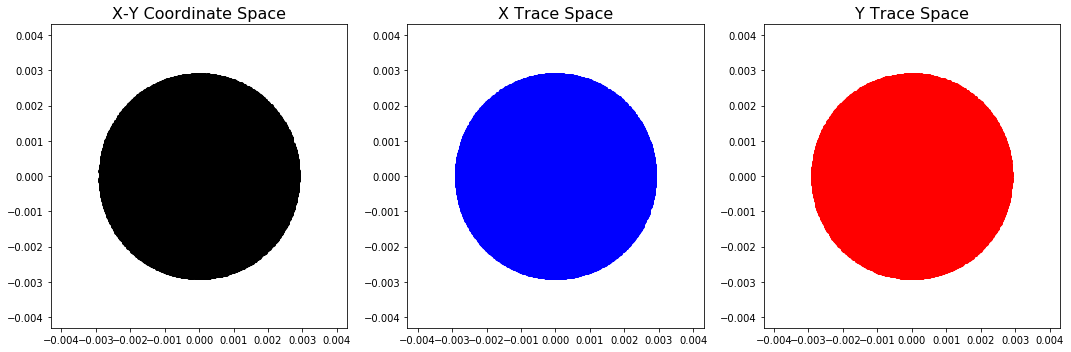

/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=-0.0
  'bottom=%s, top=%s') % (bottom, top))


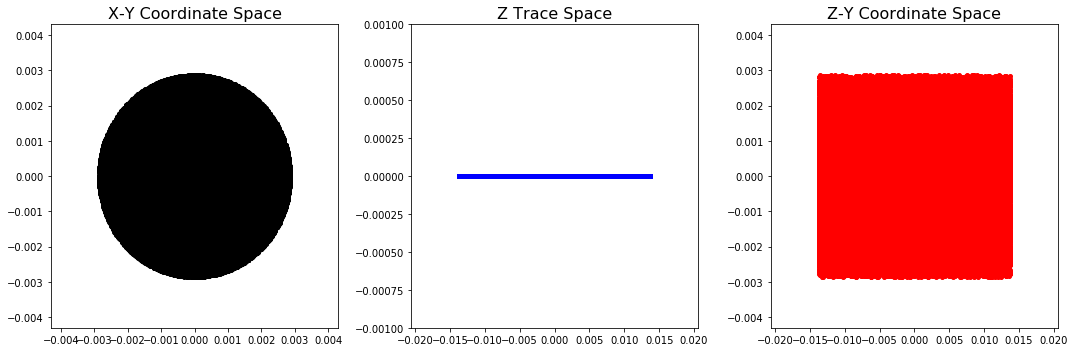

In [11]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

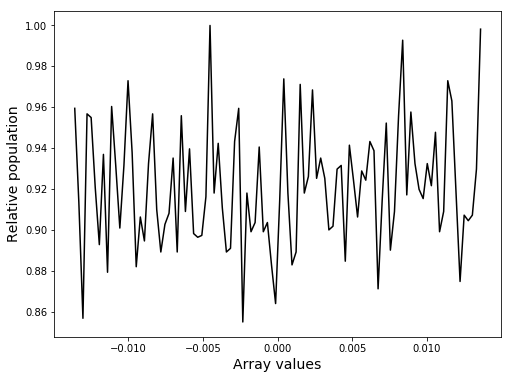

In [12]:
#Look at z distribution
part = myBunch.get_local_particles()
part[:,4]
zvals = part[:,4]
utils.plot_distribution(zvals, 100)

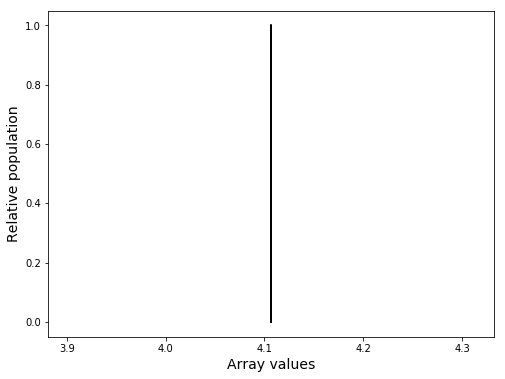

In [13]:
#Plot the distribution in H
hArray, iArray = elliptic_sp.toy_calc_bunch_H(myBunch,opts,elliptic=False)
#hA, iA = elliptic_sp.calc_H_and_ID(myBunch,opts,elliptic=False)
utils.plot_distribution(hArray*1.e6,10)

In [14]:
#print out some bunch properties
basic_calcs.calc_properties(myBunch,reference_particle)

rms envelope x: 1.4340535983 mm
rms envelope y: 1.43444624588 mm
maximum x value is : 2.86582338151 mm
maximum y value is : 2.86506065997 mm
rms beta x: 1.00184806215
rms beta y: 1.00169564172
geometric emittance x: 2.05271617572 mm-mrad
geometric emittance y: 2.05415292493 mm-mrad
normalized emittance x: 0.149947288536 mm-mrad
normalized emittance y: 0.150052240526 mm-mrad
mean of xp^2 : 2.04892962644e-06
mean of yp^2 : 2.05067571363e-06
total geometric emittance x: 8.19779362195 mm-mrad
total geometric emittance y: 8.19467734851 mm-mrad


## Run the simulation

In [15]:
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [16]:
opts.turns = 200
opts.checkpointperiod = 50
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

## Diagnostics

We now want to plot the beam envelope. There are two simple ways to do this using the diagnostics implement for this Synergia run:

1. Use the per-step `Diagnostics_basic` to plot the RMS envelope in x/y every 1 cm.
2. Use the per-turn `Diagnostics_particle` to extract the particle coordinates and plot the RMS or full envelope every 2 cm.

We will demonstrate both methods and show their agreement.

#### 1. Plot the RMS evelope using basic diagnostics

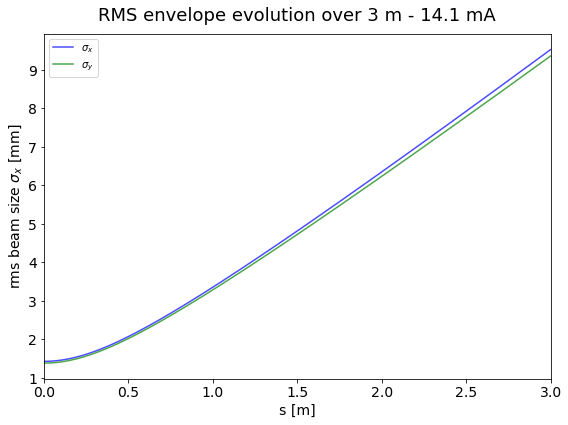

In [17]:
opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std']
plotVals = diagplot.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(xmaster,xstd*1.e3,'b-', alpha=0.7, label=r'$\sigma_x$') #plot x
ax.plot(xmaster,ystd*1.e3,'g-', alpha=0.7, label = r'$\sigma_y$') #plot y
axtitle = "RMS envelope evolution over 3 m - 14.1 mA"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,3.0])
ax.legend()
sv_title = 'SC_test_envelope.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

#### 2.Plot the RMS envelop using the turn-by-turn particles diagnostic

In [26]:
opts.relpath = opts.output_dir
#opts.relpath = 'SC_drift_test-2'
files = elliptic_sp.get_file_list(opts)
twiss = elliptic_sp.get_toy_twiss(opts)
lost = elliptic_sp.get_lost_particle_list(opts)

if len(lost) > 0:
    #we have lost particles
    opts.lost = lost #store these in opts.lost
    lost = True #make lost a simple flag

xrms_vals = []

#loop through all files and grab particles - calculate the RMS x value at each turn
for outfile in files:

    if lost:
        header, particles, lost_particles = elliptic_sp.get_particles(outfile, lost,opts.lost)
    else:
        header, particles = elliptic_sp.get_particles(outfile, lost)
    
    xrms = np.std(particles[:,0])
    
    xrms_vals.append(xrms)

zvals = (4./200)*np.asarray(list(range(201))) #construct s value parameters
xrms_vals = np.asarray(xrms_vals)*1.e3

/home/vagrant/.pyenv/versions/2.7.14/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


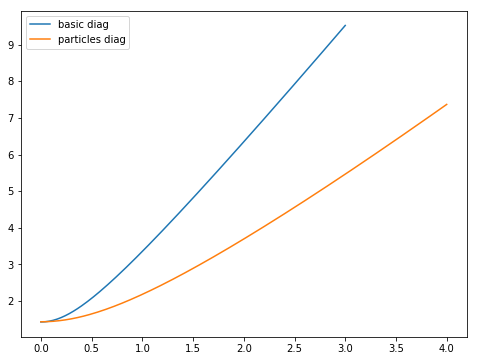

In [27]:
fig = plt.figure()
ax = fig.gca()
ax.plot(xmaster,xstd*1.e3, label = 'basic diag')
ax.plot(zvals,xrms_vals, label = 'particles diag')
ax.legend(loc=2)

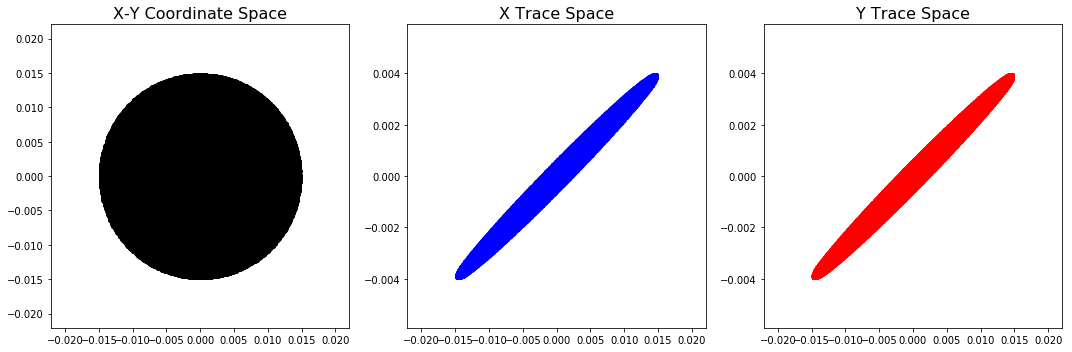

In [28]:
pltbunch.plot_bunch(myBunch)

In [29]:
basic_calcs.calc_properties(myBunch,reference_particle)

rms envelope x: 7.37200271302 mm
rms envelope y: 7.37279926328 mm
maximum x value is : 14.7184322077 mm
maximum y value is : 14.7122937251 mm
rms beta x: 3.73424259917
rms beta y: 3.73389317821
geometric emittance x: 14.5535332956 mm-mrad
geometric emittance y: 14.5580407318 mm-mrad
normalized emittance x: 1.0631098844 mm-mrad
normalized emittance y: 1.06343914466 mm-mrad
mean of xp^2 : 3.89731864201e-06
mean of yp^2 : 3.89889052445e-06
total geometric emittance x: 58.0123655331 mm-mrad
total geometric emittance y: 57.9694105653 mm-mrad


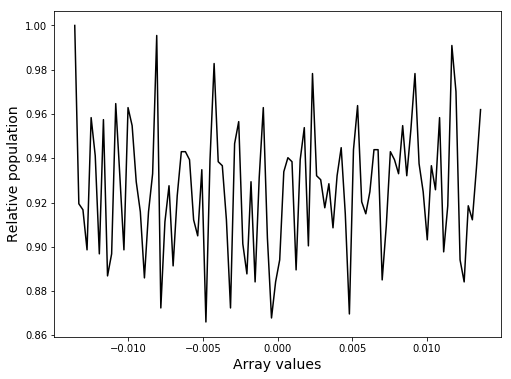

In [40]:
#Look at z distribution
part = myBunch.get_local_particles()
part[:,4]
zvals = part[:,4]
utils.plot_distribution(zvals, 100)

## Calculate the expansion from basic theory

In [31]:
def calc_perveance(I,ref,cn=0):
    '''Calculate the perveance for a proton beam of a given current and particle energy.
    
    Arguments
        - I - current in A
        - ref - the reference particle for extracting beta and gamma
        
        - (optional) charge neutralization factor - default 0
    '''
    
    I0 = 3.13e7 #characteristic current
    
    beta = ref.get_beta()
    gamma = ref.get_gamma()
    
    return (I/I0)*(2/beta**3)*(1/gamma**3)

def calc_characteristic_current():
    '''Return characteristics current for proton beam'''
    return 4*np.pi*scipy.constants.epsilon_0*scipy.constants.m_p*(scipy.constants.c**3)/scipy.constants.e

In [32]:
#Introduce numerical integrators

#2nd Order RK - Ralston Method
def Ralston(r,z,h,f):
    k1 = h*f(r)
    return 0.25*k1 + 0.75*h*f(r+(2/3)*k1)

#4th Order Runge-Kutta
def RungeKutta4(r,z,h,f):
    k1 = f(r)
    k2 = f(r + (h/2)*k1)
    k3 = f(r + (h/2)*k2)
    k4 = f(r + h*k3)
    return h/6*(k1 + 2*k2 +2*k3 + k4)

#function here, which is a function of r and z
def rprime(K,emit,r0,rp0,rm):
    '''
    
    Returns the slope of the beam envelope (dr/dz) for a given value of emittance,rm, K, and initial conditions.
    
    This equation follows from Reisier.
    
    Arguments:
    
        - r - beam radius (or RMS)
        - K - perveance
        - emit - geometric emittance
        - r0 - initial envelope radius (or RMS)
        - rp0 - initial slope of envelope (or RMS)
        
    '''
    
    first = rp0**2 #first term
    second = (emit**2)*((1./r0**2)-(1./rm**2)) #second term
    third = 2*K* np.log(rm/r0) / 4
    
    return np.sqrt(first + second + third)

In [33]:
import math
from __future__ import division

def calculate_expansion(current, reference_paricle,r0,rp0,emit=emit,N=1000,zf=opts.turns * lattice.get_length()):

    '''Evaluate the expansion of a KV beam envelope in a drift along z-axis, begining at z = 0.
    
    Arguments:
        - current - beam current in A
        - reference_particle - synergia object for bunch/lattice reference particle
        - r0 - initial envelope value (provide RMS for RMS expansion, a for envelope expansion, etc.)
        - rp0 - initial slope of envelope (must be non-zero, but calculation is not sensitive to small values)
        
        - (optional) emit - geometric emittance of beam - default 2.05721258396*1.e-6 (for 0.3 mm-mrad KV beam)
        - (optional) N - number of steps for integration - default 1000
        - (optional) zf - final z value (e.g. length of expansion) - default 50.0
        
    '''
    
    z0 = 0.0 #start
    ss = (zf-z0)/N #step size

    zpoints = np.linspace(0.0, zf, num=N) #define z values
    rpoints = [] #empty array for r values
    
    #calculate perveance
    Kp = calc_perveance(current, reference_particle)
    
    #x is r
    #z is t (what we step up)
    #f is our function describing the relationship between r and z
    f = lambda r: rprime(Kp,emit,r0,rprime0,r)

    r,z,dz = r0,z0,ss
    points = []
    while z < zf:
        points.append((z,r))
        z, r = z+dz, r + Ralston(r,z,dz,f) #incremement
        
    return points

In [21]:
#define the original bunch
particles_file = 'myKVBunch.txt'
bucket_length = bunch_length #set equal
comm = synergia.utils.Commxx(True) #define a communicator
myOrigBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myOrigBunch.get_local_particles()
local_particles[:,4] /= opts.beta

#calculate orignal x emittance
gemit_x = basic_calcs.get_emittance('x',myOrigBunch)

Loading Synergia particles from txt file:  myKVBunch.txt
Read  102400  particles


In [34]:
#Calculate current - 14 mA 
current14 = 14*1.e-3
rprime0 = 1.0*(xstd[1]-xstd[0])/(xmaster[1]-xmaster[0])
r0 = xstd[0] #1.0*1.e-3 #initial envelope value
#emit = 4.10849449506e-06 #not used (hard coded into calculate_expansion) #gemit_x  #rms geometric emittance

In [35]:
#Run the tests
points14 = calculate_expansion(current14, reference_particle, r0,rprime0)
points14_zemit = calculate_expansion(current14, reference_particle, r0,0, emit = 0)
points0 = calculate_expansion(0.0, reference_particle, r0,rprime0)

### Compare zero emittance to emittance run

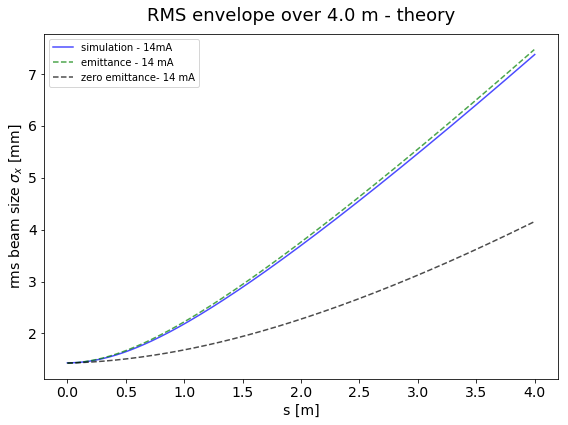

In [38]:
#Compare the results
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(zvals,xrms_vals,'b-', alpha=0.7, label = 'simulation - 14mA') #plot x
ax.plot([p[0] for p in points14], [p[1]*1.e3 for p in points14],'g--',alpha=0.7, label = 'emittance - 14 mA')
ax.plot([p[0] for p in points14_zemit], [p[1]*1.e3 for p in points14_zemit],'k--',alpha=0.7, label = 'zero emittance- 14 mA')
axtitle = "RMS envelope over %s m - theory" % (opts.turns * lattice.get_length())
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc = 2)
fig.tight_layout()
#fig.savefig('non_SC_dominated_envelope.png')

#### Compare zero current to 14 mA

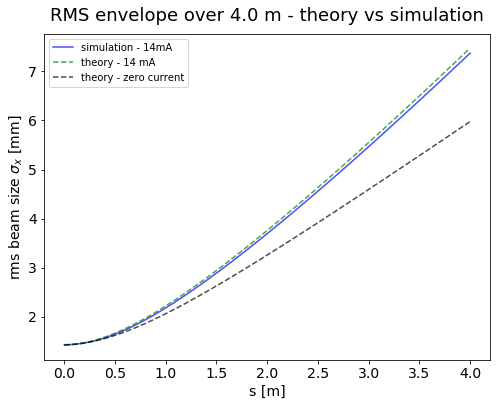

In [39]:
#Compare the results - zero current to 14 mA
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(zvals,xrms_vals,'b-', alpha=0.7, label = 'simulation - 14mA') #plot x
ax.plot([p[0] for p in points14], [p[1]*1.e3 for p in points14],'g--',alpha=0.7, label = 'theory - 14 mA')
ax.plot([p[0] for p in points0], [p[1]*1.e3 for p in points0],'k--',alpha=0.7, label = 'theory - zero current')
axtitle = "RMS envelope over %s m - theory vs simulation" % (opts.turns * lattice.get_length())
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc = 2)
#fig.tight_layout()